In [7]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## download and become one with the data(10%)

In [8]:

# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-02-20 04:06:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   175MB/s    in 0.9s    

2023-02-20 04:06:36 (175 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [9]:

# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent

Creating data loaders (preparing the data)

In [10]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")
     

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


### Setting up callbacks (things to run whilst our model trains)
Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

* Experiment tracking with TensorBoard - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.(saves model/weight at certain frequency)(checkpoint in every 10 epochs.if you need to run 100000 epochs you can make such chckpoint)
* Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when monitered metrics ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.
We'll explore each of these overtime but for this notebook, we'll see how the TensorBoard callback can be used.

The TensorBoard callback can be accessed using tf.keras.callbacks.TensorBoard().

Its main functionality is saving a model's training performance metrics to a specified log_dir.

By default, logs are recorded every epoch using the update_freq='epoch' parameter. This is a good default since tracking model performance too often can slow down model training.

To track our modelling experiments using TensorBoard, let's create a function which creates a TensorBoard callback for us.

>🔑 Note: We create a function for creating a TensorBoard callback because as we'll see later on, each model needs its own TensorBoard callback instance (so the function will create a new one each time it's run).

In [11]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub
In fact, we're going to use two models from TensorFlow Hub:

- ResNetV2 - a state of the art computer vision model architecture from 2016.
- EfficientNet - a state of the art computer vision architecture from 2019.

State of the art means that at some point, both of these models have achieved the lowest error rate on ImageNet (ILSVRC-2012-CLS), the gold standard of computer vision benchmarks.
Here are the steps I took:

Go to tfhub.dev.
* Choose your problem domain, e.g. "Image" (we're using food images).
* Select your TF version, which in our case is TF2.
* Remove all "Problem domanin" filters except for the problem you're working on.
Note: "Image feature vector" can be used alongside almost any problem, we'll get to this soon.
* The models listed are all models which could potentially be used for your problem.
🤔 Question: I see many options for image classification models, how do I know which is best?

You can see a list of state of the art models on paperswithcode.com, a resource for collecting the latest in deep learning paper results which have code implementations for the findings they report.
Since we're working with images, our target are the models which perform best on ImageNet.

You'll probably find not all of the model architectures listed on paperswithcode appear on TensorFlow Hub. And this is okay, we can still use what's available.

To find our models, let's narrow down our search using the Architecture tab.
* Select the Architecture tab on TensorFlow Hub and you'll see a dropdown menu of architecture names appear.
The rule of thumb here is generally, names with larger numbers means better performing models(more complex). For example, EfficientNetB4 performs better than EfficientNetB0.
However, the tradeoff with larger numbers can mean they take longer to compute.

🤔 Question: I thought we were doing image classification, why do we choose feature vector and not classification?
Great observation. This is where the differnet types of transfer learning come into play, as is, feature extraction and fine-tuning.
"As is" transfer learning is when you take a pretrained model as it is and apply it to your task without any changes.
passing a single image to this model will produce 1000 different prediction probability values (1 for each class).
* This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.
* Feature extraction transfer learning is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.

* Fine-tuning transfer learning is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem. This usually means training some, many or all of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.
A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (feature extraction).

 > Question: Why train only the top 2-3 layers in feature extraction?
 The lower a layer is in a computer vision model as in, the closer it is to the input layer, the larger the features it learn. For example, a bottom layer in a computer vision model to identify images of cats or dogs might learn the outline of legs, where as, layers closer to the output might learn the shape of teeth. Often, you'll want the larger features (learned patterns are also called features) to remain, since these are similar for both animals, where as, the differences remain in the more fine-grained features.

The different kinds of transfer learning. An original model, a feature extraction model (only top 2-3 layers change) and a fine-tuning model (many or all of original model get changed).




In [17]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"
     

In [18]:
# These URLs link to a saved pretrained model on TensorFlow Hub.
# When we use them in our model, the model will automatically be downloaded for us to use.
# To do this, we can use the KerasLayer() model inside the TensorFlow hub library.
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model


In [21]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [26]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [27]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


But before we call the fit function, there's one more thing we're going to add, a callback. More specifically, a TensorBoard callback so we can track the performance of our model on TensorBoard.

In [28]:

# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230220-045927
Epoch 1/5
24/24 [==============================] - 349s 15s/step - loss: 2.0028 - accuracy: 0.3253 - val_loss: 1.2245 - val_accuracy: 0.6212
Epoch 2/5
24/24 [==============================] - 400s 17s/step - loss: 0.9164 - accuracy: 0.7267 - val_loss: 0.8546 - val_accuracy: 0.7308
Epoch 3/5
24/24 [==============================] - 366s 16s/step - loss: 0.6297 - accuracy: 0.8213 - val_loss: 0.7615 - val_accuracy: 0.7524
Epoch 4/5
24/24 [==============================] - 402s 17s/step - loss: 0.4823 - accuracy: 0.8747 - val_loss: 0.6938 - val_accuracy: 0.7704
Epoch 5/5
24/24 [==============================] - 405s 17s/step - loss: 0.3796 - accuracy: 0.9120 - val_loss: 0.6674 - val_accuracy: 0.7828


It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...with only 10 percent of the training images!

That goes to show the power of transfer learning. And it's one of the main reasons whenever you're trying to model your own datasets, you should look into what pretrained models already exist.

In [29]:
# Tidbit: If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
# from helper import plot_loss_curves
import matplotlib.pyplot as plt
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

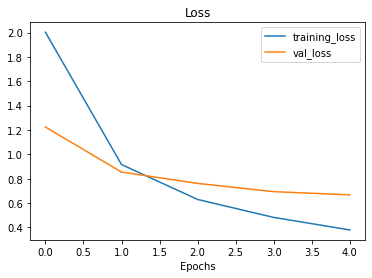

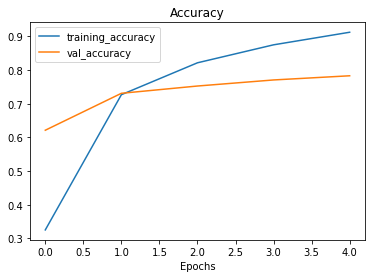

In [30]:
plot_loss_curves(resnet_history)

In [31]:
# Resnet summary 
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [32]:
# Okay, we've trained a ResNetV250 model, time to do the same with EfficientNetB0 model.
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=4, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])
     

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230220-053406
Epoch 1/4
24/24 [==============================] - 166s 7s/step - loss: 1.8935 - accuracy: 0.4293 - val_loss: 1.3084 - val_accuracy: 0.7416
Epoch 2/4
24/24 [==============================] - 175s 8s/step - loss: 1.0617 - accuracy: 0.7813 - val_loss: 0.8642 - val_accuracy: 0.8268
Epoch 3/4
24/24 [==============================] - 175s 8s/step - loss: 0.7521 - accuracy: 0.8373 - val_loss: 0.6882 - val_accuracy: 0.8496
Epoch 4/4
24/24 [==============================] - 182s 8s/step - loss: 0.6061 - accuracy: 0.8627 - val_loss: 0.6045 - val_accuracy: 0.8616


The EfficientNetB0 model does even better than the ResNetV250 model! Achieving over 85% accuracy on the test set...again with only 10% of the training data.

How cool is that?

With a couple of lines of code we're able to leverage state of the art models and adjust them to our own use case.

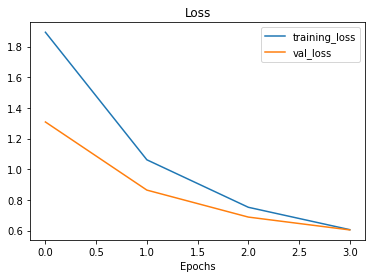

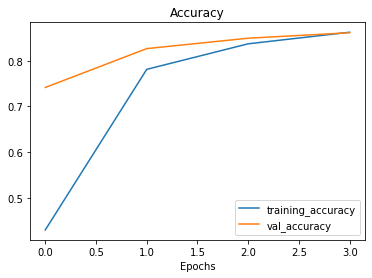

In [33]:
plot_loss_curves(efficientnet_history)

In [34]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [35]:
# how many layer our efficient net have?
len(efficientnet_model.layers[0].weights)

309

### Comparing our models result with tensorboard
when you upload to tensorboard dev, your experiments are public.


In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

# Done. View your TensorBoard at https://tensorboard.dev/experiment/YWgIQ4MfQaamvjgA8ADvsA/

In [39]:
# Check out experiments we have public in tensorboard.dev
!tensorboard dev list

2023-02-20 06:22:08.021312: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-20 06:22:08.021419: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-20 06:22:08.021442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-02-20 06:22:09.331154: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to c

In [41]:
# Delete an experiment
# !tensorboard dev delete --experiment_id YWgIQ4MfQaamvjgA8ADvsA

https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tbdev_getting_started.ipynb#scrollTo=n2PvxhOkW7vn

In [42]:
# Check to see if experiments still exist
!tensorboard dev list
     

2023-02-20 06:25:15.509062: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-20 06:25:15.509183: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-20 06:25:15.509207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-02-20 06:25:16.775238: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to c